## 1. Abstract
In this report I analyze a dataset of 12,624 different NFL player prop bets from four major sportsbooks (DraftKings, ESPN BET, BetMGM, and Pinnacle), evaluate two different methods of adjusting implied probability to true probability (Power vs Multiplicative),  and lastly identify which sportbook in the dataset is the sharpest.

My findings show that of the four major sportsbooks in the dataset, Pinnacle is the sharpest. My findings also reveal that the favorite-longshot bias is considered when sportsbooks distribute vigorish, and therefore accounting for this yields better true probability estimates. 


## 2. Data Pre-Processing
The initial step in refining the dataset involved establishing a baseline from which to filter. This entailed extracting the closing lines for each sportsbook across all player prop markets and bets, totaling 261,525 bets.

In [2]:
import numpy as np
import pandas as pd
import os
base_path = './historical_data/football/NFL/'
player_props = [x for x in os.listdir(base_path) if x.startswith('Player') and 'Fantasy' not in x.split()]
sportsbooks = ['DraftKings', 'ESPN BET', 'BetMGM', 'Pinnacle']

def get_closing_lines_for_market(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    non_book_cols = ["sport", "league", "start_date", "game_id", "home_team", "home_team_id", 
                     "away_team", "away_team_id", "market", "name", "grade", "desired", "outcome"]
    book_cols = df.columns.difference(non_book_cols + ['timestamp'])
    new_df = df.sort_values(by='timestamp', ascending=False).groupby('name', as_index=False).first()
    return new_df

dfs = []
for prop_market in player_props:
    market_path = os.path.join(base_path, prop_market)
    for csv_file in os.listdir(market_path):
        file_path = os.path.join(market_path, csv_file)
        df = pd.read_csv(file_path)
        if 'outcome' in df.columns:
            closing_lines_df = get_closing_lines_for_market(df)
            dfs.append(closing_lines_df)

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Total Player Props Collected: {combined_df.shape[0]}")

Total Player Props Collected: 261525


However, not every book has a recorded closing line for all of these bets. This is a challenge that is common in data cleaning. In order to ensure accuracy of results, analysis was only conducted on the 4 major sportsbooks with the most recorded data. These 4 are DraftKings, ESPN BET, BetMGM, and Pinnacle. The 261,525 bets were filtered down to 15,456 bets in which there was a definitive result (refunded bets thrown out) and odds are present from all four of our sportsbooks of interest.

In [3]:
df = combined_df[['game_id', 'start_date', 'home_team', 'away_team', 'market', 'name', 'grade', 'desired', 'outcome'] + sportsbooks]
df = df[(df['grade'] == 'Won')|(df['grade'] == 'Lost')]
df = df.dropna(subset=sportsbooks, how='any')
print(f"Remaining Player Props: {df.shape[0]}")
df[['market', 'name']+ sportsbooks +['grade','desired','outcome']].head(3)

Remaining Player Props: 15456


,market,name,DraftKings,ESPN BET,BetMGM,Pinnacle,grade,desired,outcome
793,Player Passing Attempts,Mac Jones Over 33.5,-115.0,-120.0,-120.0,-121.0,Lost,33.5,20.0
794,Player Passing Attempts,Mac Jones Under 33.5,-115.0,-110.0,-110.0,-109.0,Won,33.5,20.0
815,Player Passing Attempts,Justin Fields Over 27.5,-115.0,-150.0,-115.0,-133.0,Won,27.5,32.0


Next, Odds from each sportsbook were converted to implied probabilities using the standard american odds conversion formulas.

$$ Negative \: American \: Odds: \;\;\;\; Implied \: Probability = \frac{|Odds|}{|Odds| + 100}$$
$$ Positive \: American \: Odds: \;\;\;\; Implied \: Probability = \frac{100}{Odds + 100}$$

In [4]:
def american_odds_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100) 
    else: 
        return abs(odds) / (abs(odds) + 100) 
df[sportsbooks] = df[sportsbooks].applymap(american_odds_to_implied_probability)
df['grade'] = df['grade'].map({'Won': 1, 'Lost': 0})
df[['market', 'name']+ sportsbooks +['grade','desired','outcome']].head(3)

,market,name,DraftKings,ESPN BET,BetMGM,Pinnacle,grade,desired,outcome
793,Player Passing Attempts,Mac Jones Over 33.5,0.534884,0.545455,0.545455,0.547511,0,33.5,20.0
794,Player Passing Attempts,Mac Jones Under 33.5,0.534884,0.523810,0.523810,0.521531,1,33.5,20.0
815,Player Passing Attempts,Justin Fields Over 27.5,0.534884,0.600000,0.534884,0.570815,1,27.5,32.0


Next, the implied probabilities are adjusted to be true probabilities by removing the vigorish, or "vig". Several adjustment methods have been developed to accomplish this, the most popular method being the multiplicative (normalization) method. This is what is employed in the [OddsJam No-Vig Fair Odds Calculator](https://oddsjam.com/betting-calculators/no-vig-fair-odds). The process of removing the vigorish from implied probabilities is crucial as it serves as the foundation of the positive EV betting strategy. The multiplicative adjustment method expresses the true probability for the $i$ th outcome, $p_{i}$, as 

$$ p_{i} = \frac{\pi_{i}}{\pi} $$

where $\pi$ is the total of the implied probabilities. The popularity of this approach can be attributed to its simplicity. The major limitation of this appraoch is that it fails to account for the Favourite-longshot bias, a well documented phenomenon in economics and gambling that says favorites are under-bet and underdogs are over-bet. The consequences of this phenomenon are that Bookmakers distribute a greater proportion of the vig to longshot bets rather than favorites. The power adjustment method is designed to overcome this limitation, it expresses the true probability for the the $i$ th outcome, $p_{i}$, as 

$$ p_{i} = \pi_{i}^k $$

where the value of $k$ is fine-tuned through an optimization process that ensures the sum of all adjusted probabilities, $\Sigma p_{i} $, equals 1. The exponential nature of this method allows it to apply greater adjustments to underdogs than favorites, thus accounting for the favorite-longshot bias, and ultimately giving us a better reflection of the true probability. Both methods are used to see which yields better true probability values.

In [191]:
from scipy.optimize import minimize
import pandas as pd
def calc_vig(k, prob_under, prob_over):
    adjusted_under = prob_under ** k
    adjusted_over = prob_over ** k
    return abs((adjusted_under + adjusted_over) - 1)

def calc_true_prob(row, betting_companies):
    results = {}
    k_initial = 1 
    for company in betting_companies:
        prob_under = row[f'{company}_under']
        prob_over = row[f'{company}_over']
        # Using scipy's minimize function to find the optimal k
        res = minimize(calc_vig, k_initial, args=(prob_under, prob_over))
        k_optimal = res.x[0]
        
        results[f'{company}_true_power_under'] = prob_under ** k_optimal
        results[f'{company}_true_power_over'] = prob_over ** k_optimal
        
        total_prob = prob_under + prob_over
        results[f'{company}_true_mult_under'] = prob_under / total_prob
        results[f'{company}_true_mult_over'] = prob_over / total_prob
    return pd.Series(results)

def align_bets_and_calc_true_prob(df, sportsbooks):
    for term, new_column_name in [('Under', 'match_key_under'), ('Over', 'match_key_over')]:
        mask = df['name'].apply(lambda x: x.strip().split()[-2] == term)
        df.loc[mask, new_column_name] = df.loc[mask, 'name'].str.replace(f' {term}', '', case=False)
    
    df['match_key'] = df[['match_key_under', 'match_key_over']].bfill(axis=1).iloc[:, 0]
    matched_df = pd.merge(df[df['match_key_under'].notnull()], df[df['match_key_over'].notnull()], on=['game_id', 'market', 'match_key'], suffixes=('_under', '_over'))
    
    true_values_df = matched_df.apply(lambda row: calc_true_prob(row, sportsbooks), axis=1)
    matched_df_true = pd.concat([matched_df, true_values_df], axis=1)                      
    return matched_df_true

def simplify_df_columns(df, suffix):
    return df[[col for col in df.columns if col.endswith(suffix) or col == 'market']].rename(columns=lambda x: x.replace(f'_{suffix}', ''))
    
matched_df_true = align_bets_and_calc_true_prob(df, sportsbooks)
df_under = simplify_df_columns(matched_df_true, 'under')
df_over = simplify_df_columns(matched_df_true, 'over')
df_stacked = pd.concat([df_under, df_over], axis=0).reset_index(drop=True)
mult_df = df_stacked[['market','name'] + [f'{x}_true_mult' for x in sportsbooks] + ['grade', 'desired', 'outcome']]
power_df = df_stacked[['market','name'] + [f'{x}_true_power' for x in sportsbooks] + ['grade', 'desired', 'outcome']]

Given that both sides of a bet are necessary to remove the vig from one side, any "Over" bet that did not have a corresponding "Under" bet had to be removed. This leaves us with our final cleaned and pre-processed dataset.

##### Multiplicative Method Dataset:

In [192]:
print(f"Remaining Player Props: {mult_df.shape[0]}")
mult_df.head(3)

Remaining Player Props: 12624


,market,name,DraftKings_true_mult,ESPN BET_true_mult,BetMGM_true_mult,Pinnacle_true_mult,grade,desired,outcome
0,Player Passing Attempts,Mac Jones Under 33.5,0.500000,0.489879,0.489879,0.487849,1,33.5,20.0
1,Player Passing Attempts,Justin Fields Under 27.5,0.500000,0.436681,0.500000,0.466934,0,27.5,32.0
2,Player Passing Attempts,Justin Fields Under 28.5,0.489879,0.489879,0.489879,0.477943,0,28.5,32.0


##### Power Method Dataset:

In [193]:
print(f"Remaining Player Props: {power_df.shape[0]}")
power_df.head(3)

Remaining Player Props: 12624


,market,name,DraftKings_true_power,ESPN BET_true_power,BetMGM_true_power,Pinnacle_true_power,grade,desired,outcome
0,Player Passing Attempts,Mac Jones Under 33.5,0.500000,0.488796,0.488796,0.486554,1,33.5,20.0
1,Player Passing Attempts,Justin Fields Under 27.5,0.500000,0.430331,0.500000,0.463311,0,27.5,32.0
2,Player Passing Attempts,Justin Fields Under 28.5,0.488796,0.488796,0.488796,0.475495,0,28.5,32.0


## 3. Analysis 

The remaining 12,624 bets are visualized below:

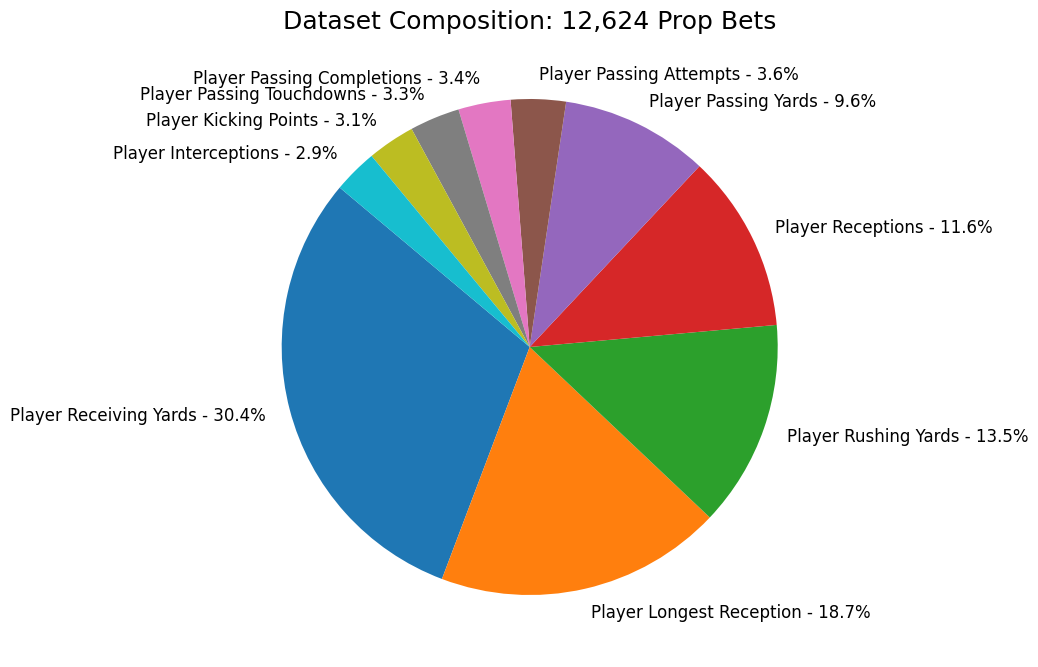

In [194]:
import matplotlib.pyplot as plt
market_counts = power_df['market'].value_counts()
labels=[f'{label} - {value/sum(market_counts.values)*100:.1f}%' for label, value in market_counts.items()]
plt.figure(figsize=(8, 9))
plt.pie(market_counts, startangle=140, labels = labels)
plt.title('Dataset Composition: 12,624 Prop Bets', loc='center', fontsize=18)
plt.show()

My first attempt in analyzing the sharpness of the 4 sportsbooks involved calculating Brier Scores. The Brier Score is the Mean Squared Error equivalent metric for evaluating forecasted probabilities against binary outcomes. It is expressed as 

$$ BS  = \frac{1}{N} \Sigma^{N}_{t=1} (f_{t} - o_{t})^2 $$

Brier scores are bounded by [0,1], 0 representing perfect accuracy and 1 representing perfect inaccuracy. Thus, the lesser the score, the better. 

In [195]:
for book in sportsbooks:
    predicted_power = power_df[book + '_true_power']
    actual_power = power_df['grade']
    brier_score_power = np.mean((predicted_power - actual_power) ** 2)
    predicted_mult = mult_df[book + '_true_mult']
    actual_mult = mult_df['grade']
    brier_score_mult = np.mean((predicted_mult - actual_mult) ** 2)
    brier_scores[book] = [brier_score_power, brier_score_mult]
brier_scores_df = pd.DataFrame(brier_scores, index=['Power Method', 'Multiplicative Method']).T
pd.DataFrame(brier_scores_df['Power Method'].sort_values(ascending = True))

,Power Method
Pinnacle,0.247429
ESPN BET,0.248400
BetMGM,0.248942
DraftKings,0.249184


In [196]:
pd.DataFrame(brier_scores_df['Multiplicative Method'].sort_values(ascending = True))

,Multiplicative Method
Pinnacle,0.247508
ESPN BET,0.248662
DraftKings,0.248961
BetMGM,0.249182


Our analysis reveals similar, yet slightly different results. Both adjustment methods identify Pinnacle as the leading bookmaker in terms of accuracy, followed by ESPN BET, with discrepancies observed in the rankings of BetMGM and DraftKings. 

Given that the difference in magnitude between all scores is very small, it's unclear whether or not these results statistically significant. Further analysis is still necessary to determine which book is the sharpest. 

The similarity in scores stems from the binary nature of our target variable (0 or 1), coupled with the industry practice among sportsbooks of maintaining very similar odds to deter arbitrage betting. In order gain more definitive insights, we can define a new metric to relate the actual outcomes of bets relative to their desired outcomes.

Let this new metric be called distance to desired outcome and it can be calculated as follows:


$$ Over \: Bets:  \: \: \: Distance = Outcome − Desired $$
$$ Under \: Bets: \: \: \: Distance = Desired - Outcome $$

This formula is inverted to maintain a consistent target variable across all bets. This approach aims to correlate the variable with accurate true probabilities. The sportsbook demonstrating the strongest correlation with this variable is considered the most precise in its predictions.

The metric is valuable because it provides a medium to perform correlation analysis and ultimately determine which sportsbook is the sharpest. Since our dataset includes different player prop markets, it's imperative to first normalize this target variable according to the market. (i.e. 1 interception shouldn't be the same as 1 rushing yard)

In [198]:
# Normalizing both dataframes
for market in power_df['market'].unique():
    market_df = power_df[power_df['market'] == market].copy()
    for column in ['desired', 'outcome']:
        min_value = market_df[column].min()
        max_value = market_df[column].max()
        power_df.loc[market_df.index, f'{column}_norm'] = (market_df[column] - min_value) / (max_value - min_value)
for market in mult_df['market'].unique():
    market_df = mult_df[mult_df['market'] == market].copy()
    for column in ['desired', 'outcome']:
        min_value = market_df[column].min()
        max_value = market_df[column].max()
        mult_df.loc[market_df.index, f'{column}_norm'] = (market_df[column] - min_value) / (max_value - min_value)

# Calculating distance to desired outcome for both dataframes
power_df = power_df.copy()
power_df['bet_type'] = power_df['name'].apply(lambda x: 'under' if 'Under' in x else 'over')
power_df['distance'] = power_df.apply(lambda row: row['outcome_norm'] - row['desired_norm'] if row['bet_type'] == 'over' else row['desired_norm'] - row['outcome_norm'], axis=1)

mult_df = mult_df.copy()
mult_df['bet_type'] = mult_df['name'].apply(lambda x: 'under' if 'Under' in x else 'over')
mult_df['distance'] = mult_df.apply(lambda row: row['outcome_norm'] - row['desired_norm'] if row['bet_type'] == 'over' else row['desired_norm'] - row['outcome_norm'], axis=1)

# Calculating Pearson Correlation Coefficients 
corr_df = {}
for book in sportsbooks:
    power_val = power_df['distance'].corr(power_df[f'{book}_true_power'])
    mult_val = mult_df['distance'].corr(mult_df[f'{book}_true_mult'])
    corr_df[book] = [power_val, mult_val]
corr_df = pd.DataFrame(corr_df, index = ['Correlation (Power)', 'Correlation (Multiplicative)'])

corr_power = corr_df.loc['Correlation (Power)'].sort_values(ascending = False)
pd.DataFrame(corr_power)

,Correlation (Power)
Pinnacle,0.131866
ESPN BET,0.130737
BetMGM,0.122552
DraftKings,0.111551


In [199]:
corr_mult = corr_df.loc['Correlation (Multiplicative)'].sort_values(ascending=False)
pd.DataFrame(corr_mult)

,Correlation (Multiplicative)
Pinnacle,0.131301
ESPN BET,0.115561
BetMGM,0.110739
DraftKings,0.107577


## 4. Conclusion

This analysis not only confirms Pinnacle as the sharpest among the four sportsbooks but also strongly indicates the presence of the favorite-longshot bias within our data, suggesting sportsbooks take this into account. Consequently, the power method emerges as potentially superior to the industry-standard multiplicative method for adjusting odds. The comparative analysis, underscored by Pearson correlation coefficients between each sportsbook's true odds and the distance to the desired outcome metric, reveals the power method's superior performance.

Every value in the Power dataframe exceeds its counterpart in the multiplicative dataframe, highlighting the effectiveness of the power method. Further research into this is definitely waranted, especially considering the significant implications of even a minor advantage of the power method over the multiplicative method. This is because the computation of No-Vig Fair Odds lays the foundation for the EV formula, the performance boost from more accurate values could have a meaningful impact on the profitability of Positive EV betting as a whole.